In [ ]:
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [ ]:
# !pip install numba

# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

In [1]:
!pip install jaxopt
!pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
import jax
import jaxopt
import jax.numpy as jnp
from jax import random, grad, vmap, jit, hessian, lax
from jax.example_libraries import optimizers
from jax.nn import relu
from jax.nn import silu
from jax import config
from jax.numpy import index_exp as index
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import pickle

from scipy.interpolate import griddata
from scipy.integrate import dblquad
%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 4.3 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


# GPU Setup


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Wed Apr 24 21:27:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0              25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Problem Setup**



**Heat Equation on 2D Rectangle**

$$\frac{\partial u}{\partial t}=\kappa\nabla^2u = \kappa(\frac{\partial^2 u}{\partial x^2}+\frac{\partial^2 u}{\partial y^2}), \quad (x,y)\in D, \quad t \in [0,T] , \quad \kappa>0$$

$$u(x,y,t) = 0, \quad (x,y)\in \partial D$$

$$\quad u(x,y,0)=f(x,y), \quad (x,y)\in D$$

where $D$ is the rectangle $D = [0,x_0] \times [0,y_0]$, $\kappa$ denotes the thermal diffusivity, $\ f(x)$ is our initial condition .



**Training data**

$$\mathcal{L}_{training}(\theta)= \frac{1}{N_{\rm training}P_{\rm training}}\sum_{i=1}^{N_{\rm training}}\sum_{j=1}^{P_{\rm training}}\left|u_i(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j}) -\tilde{{\cal G}}({\bf f}_{i})(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j})\right|^2$$

$f_{\rm training}\in{\mathbb R}^{N_{\rm training} \ \times \ {\rm m}}=$ Evaluations of the input functions at the $m$ sensor points (*sensors*) $\left(i.e. \ {\mathbf f}_{\rm i}(x)(y)=[{\rm f}_{\rm i}(x_1)(y_1), {\rm f}_{\rm i}(x_2)(y_2), \dots, {\rm f}_{\rm i}(x_m)(y_m)] \ , \forall {\rm i} \in N_{\rm training} \right)$.

$z_{\rm training}\in{\mathbb R}^{N_{\rm training} \ \times \ P_{\rm training} \ \times \ 3}= $ A different set of uniformly sampled collocation points for each input
$\left(i.e. \ \{(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j})\}_{\substack{\rm i=1, \rm j=1}}^{\substack{N_{\text{training}}, P_{\text{training}}}}\sim{\cal U}([0,x_0] \times [0,y_0]\times(0,T))\right)$

$u_{\rm training}\in{\mathbb R}^{N_{\rm training} \ \times \ P_{\rm training}}= $ Solution of the PDE at respective collocation points $\left(i.e. \ u_{\rm i}(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j}) \ \forall {\rm i} \in N_{\rm training}\right)$


In summary,

$$\underset{Data \ Required \ to \ Compute \ Training \ Loss}{\underbrace {f_{\rm training}, \ z_{\rm training}, \ u_{\rm training}}}$$

And similarly we have,

**Test Data**

$$\mathcal{L}_{Test}(\theta)= \frac{1}{N_{\rm test}P_{\rm test}}\sum_{i=1}^{N_{\rm test}}\sum_{j=1}^{P_{\rm test}}\left|u_i(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j}) -\tilde{{\cal G}}({\bf f}_{i})(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j})\right|^2$$

$f_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ {\rm m}}=$ Evaluations of the input functions at the $m$ sensor points (*sensors*) $\left(i.e. \ {\mathbf f}_{\rm i}(x)(y)=[{\rm f}_{\rm i}(x_1)(y_1), {\rm f}_{\rm i}(x_2)(y_2), \dots, {\rm f}_{\rm i}(x_m)(y_m)] \ , \forall {\rm i} \in N_{\rm test} \right)$.

$z_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{\rm test} \ \times \ 3}= $ A different set of uniformly sampled collocation points for each input
$\left(i.e. \ \{(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j})\}_{\substack{\rm i=1, \rm j=1}}^{\substack{N_{\text{test}}, P_{\text{test}}}}\sim{\cal U}([0,x_0] \times [0,y_0]\times(0,T))\right)$

$u_{\rm test}\in{\mathbb R}^{N_{\rm test} \ \times \ P_{\rm test}}= $ Solution of the PDE at respective collocation points $\left(i.e. \ u_{\rm i}(x_{\rm i,j},y_{\rm i,j},t_{\rm i,j}) \ \forall {\rm i} \in N_{\rm test}\right)$


In summary,
$$\underset{Data \ Required \ to \ Compute \ Test \ Loss}{\underbrace {f_{\rm test}, \ z_{\rm test}, \ u_{\rm test}}}$$



# **Auxiliary Functions**

We sample our initial condition $f(x,y)$, by constructing a product of two functions where each function takes the sum of sine terms with random coefficients obtained from a zero-mean Gaussian distribution$.




Specifically, the function takes the form:


$$f(x,y) = f_1(x) \cdot f_2(y) $$

$$f_1(x) = \sum^{N}_{m=1}c_m{\rm sin}(\frac{m\pi x}{x_0}),$$
$$f_2(y) = \sum^{N}_{n=1}d_n{\rm sin}(\frac{n\pi y}{y_0}),$$

where $N$ denotes the number of sine terms, $ c_m, d_n\sim\mathcal{N}(0, A^2)$ represents the sampled coefficients, where $A$ is the amplitude scaling factor.


In [3]:
def generate_fourier_sine(N, A, x0, key):
    """Generate an Fourier Series representation sine function that's 2π-periodic and has zero mean in the interval [-π, π].

    Args:
        N (int): Number of sine terms to include in the Fourier series.
        A (float): Amplitude of sine terms.
        key (jax.random.PRNGKey): A random number generator key.

    Returns:
        callable: A Fourier-sine function.
    """
    # Generate random coefficients for the sine terms
    # coefficients = A * random.normal(key, (N,))
    coefficients = random.uniform(key, shape=(N,), minval=100, maxval=200)

    def sine_function(x):
        sine_terms = jnp.zeros_like(x)
        for m in range(1,N+1):
            sine_terms += coefficients[m-1] * jnp.sin(m * x / x0)

        # Set small values to zero
        threshold = 1e-14
        sine_terms = jnp.where(jnp.abs(sine_terms) < threshold, 0, sine_terms)

        return sine_terms

    return sine_function, coefficients

In [4]:
def generate_f(x, y, N, A, x0, y0, key):
    # Generate subkeys
    subkeys = random.split(key, 2)
    f1, _ = generate_fourier_sine(N, A, x0, subkeys[0])
    f2, _ = generate_fourier_sine(N, A, y0, subkeys[1])

    return jnp.outer(f1(x), f2(y)).reshape(-1,1)

In [5]:
# 3D plot function
def plot_3d(ax, X, Y, u):
    surf = ax.plot_surface(X, Y, u, cmap='plasma')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel('$u(x,y,t)$')

In [6]:
# Color plot function
def plot(ax, X, Y, u):
    pcm = ax.pcolor(X, Y, u, cmap='plasma')
    plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

In [7]:
# Error plot function
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='#440154'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x')
  ax1.set_ylabel('u')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)

# **Data Generation**

### Define Hyperparameter Settings

In [8]:
# Define hyperparameters and grid:
kappa = 1
T_lim = 1 # corresponds to T

#Size of rectangle
x0 = 1
y0 = 1


# Initial condition
num_fourier_terms = 2  # Number of sine terms in the Fourier series
sine_amplitude = 0.2  # Amplitude of the sine terms

# Training data
m = 100   # grid size in each dimention for discretizing the inhomogenuoes term, which mean that m is the branch net input dimention and it has to be a perfect square
N_train = 2**9  # number of inhomogenuoes term candidates ( i.e f)
P_train = 4**6 # number of evaluation points for each training loss


#----------------------------------TESTING-------------------------------

# Test data
N_test = 2**7 # number of test functions
P_test = 3**6 # number of test collocation points

## **Generate DeepONet Data**

# **Testing**


In [9]:
def f_testing(N, key):
    subkeys = random.split(key, 2)
    f1, c_m = generate_fourier_sine(N, sine_amplitude, x0, subkeys[0])
    f2, d_n = generate_fourier_sine(N, sine_amplitude, y0, subkeys[1])
    f_xy = lambda x,y : jnp.outer(f1(x), f2(y)).reshape(-1,1)
    return f_xy, c_m, d_n

In [10]:
def v_mn(m, n, x, y):
    threshold = 1e-14
    sine_terms = jnp.sin(m * jnp.pi * x / x0) * jnp.sin(n * jnp.pi * y / y0)
    return jnp.where(jnp.abs(sine_terms) < threshold, 0, sine_terms)

In [11]:
def A_mn(c_m, d_n):
  return jnp.outer(c_m, d_n)

In [12]:
def u(A_mn, x, y, t):
    u_total = 0
    for m in range(1, A_mn.shape[0]+1):
      for n in range(1, A_mn.shape[1]+1):
        u_total +=  A_mn[m-1][n-1] * v_mn(m, n, x, y) * jnp.exp(-(jnp.pi**2)*((m**2/x0**2)+(n**2/y0**2)) * t)
    return u_total

In [13]:
# Geneate train data corresponding to one input sample
def generate_one_training_data(key, P_train):

    # Generate subkeys
    subkeys = random.split(key, 6)
    # Sample collocation points
    x_train = random.uniform(subkeys[0], minval = 0, maxval = x0, shape = (round(P_train**(1/3)),))
    y_train = random.uniform(subkeys[1], minval = 0, maxval = y0, shape = (round(P_train**(1/3)),))
    t_train = random.uniform(subkeys[2], minval = 0, maxval = T_lim + 1e-10, shape = (round(P_train**(1/3)),))
    x_train_mesh, y_train_mesh, t_train_mesh = jnp.meshgrid(x_train, y_train, t_train, indexing="ij")
    x_train = x_train_mesh.flatten().reshape(-1,1)
    y_train = y_train_mesh.flatten().reshape(-1,1)
    t_train = t_train_mesh.flatten().reshape(-1,1)

    # training collocation points
    z_train = jnp.hstack([x_train, y_train, t_train]) # stack coordinates pairwise (x, y, t)

    # Input sensor locations and measurements
    x_sensor = jnp.linspace(0, x0, int(m**0.5), endpoint = True)
    y_sensor = jnp.linspace(0, y0, int(m**0.5), endpoint = True)

    # x_sensor_mesh, y_sensor_mesh = jnp.meshgrid(x_sensor, y_sensor)
    # x_sensor = x_sensor_mesh.flatten().reshape(-1,1)
    # y_sensor = y_sensor_mesh.flatten().reshape(-1,1)

    f, c_m, d_n = f_testing(2, subkeys[3])
    f_sensor = f(x_sensor,y_sensor)
    f_train = jnp.tile(f_sensor.T, (P_train,1))
    u_train = u(A_mn(c_m, d_n), z_train[:,0],z_train[:,1],z_train[:,2])

    return f_train, z_train, u_train

In [14]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, P_test):

    # Generate subkeys
    subkeys = random.split(key, 6)
    # Sample collocation points
    x_test = random.uniform(subkeys[0], minval = 0, maxval = x0, shape = (round(P_test**(1/3)),))
    y_test = random.uniform(subkeys[1], minval = 0, maxval = y0, shape = (round(P_test**(1/3)),))
    t_test = random.uniform(subkeys[2], minval = 0, maxval = T_lim, shape = (round(P_test**(1/3)),))
    x_test_mesh, y_test_mesh, t_test_mesh = jnp.meshgrid(x_test, y_test, t_test, indexing="ij")
    x_test = x_test_mesh.flatten().reshape(-1,1)
    y_test = y_test_mesh.flatten().reshape(-1,1)
    t_test = t_test_mesh.flatten().reshape(-1,1)

    # Testing collocation points
    z_test = jnp.hstack([x_test, y_test, t_test]) # stack coordinates pairwise (x, y, t)

    # Input sensor locations and measurements
    x_sensor = jnp.linspace(0, x0, int(m**0.5), endpoint = True)
    y_sensor = jnp.linspace(0, y0, int(m**0.5), endpoint = True)

    # x_sensor_mesh, y_sensor_mesh = jnp.meshgrid(x_sensor, y_sensor)
    # x_sensor = x_sensor_mesh.flatten().reshape(-1,1)
    # y_sensor = y_sensor_mesh.flatten().reshape(-1,1)

    f, c_m, d_n = f_testing(2, subkeys[3])
    f_sensor = f(x_sensor,y_sensor)
    f_test = jnp.tile(f_sensor.T, (P_test,1))
    u_test = u(A_mn(c_m, d_n), z_test[:,0],z_test[:,1],z_test[:,2])

    return f_test, z_test, u_test

In [15]:
# Select N keys to create N Functions
key = random.PRNGKey(11)
keys = random.split(key, N_train)

config.update("jax_enable_x64", True)
f_train, z_train, u_train = vmap(generate_one_training_data, (0, None))(keys, P_train)

#Reshape Data
f_train = jnp.float32(f_train.reshape(N_train * P_train,-1))
z_train = jnp.float32(z_train.reshape(N_train * P_train,-1))
u_train = jnp.float32(u_train.reshape(N_train * P_train,-1))
config.update("jax_enable_x64", False)

In [16]:
key = random.PRNGKey(4568) # different key than training data
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
f_test1, z_test1, u_test1 = vmap(generate_one_test_data, (0, None))(keys, P_test)

#Reshape Data
f_test = jnp.float32(f_test1.reshape(N_test * P_test,-1))
z_test = jnp.float32(z_test1.reshape(N_test * P_test,-1))
u_test = jnp.float32(u_test1.reshape(N_test * P_test,-1))

config.update("jax_enable_x64", False)

In [17]:
# Data generator
class DataGenerator(data.Dataset):
    def __init__(self, f, z, labels,
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.f = f # input
        self.z = z # location
        self.labels = labels # labeled data evaluated at y

        self.N = f.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        f = self.f[idx,:]
        z = self.z[idx,:]
        labels = self.labels[idx,:]
        # Construct batch
        inputs = (f, z)
        outputs = labels
        return inputs, outputs

# **DeepONet**

In [18]:
# Define the neural net
def MLP(layers, activation=silu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = jnp.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs
  return init, apply

In [127]:
# Define the model
class DeepONet:
    def __init__(self, branch_layers, trunk_layers, loss_type="l2", huber_delta=0.4):
        # Network initialization and evaluation functions
        self.branch_init, self.branch_apply = MLP(branch_layers, activation=jnp.tanh)
        self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=jnp.tanh)

        # Initialize
        branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
        trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
        params = (branch_params, trunk_params)

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                                                                      decay_steps=2000,
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)

        self.itercount = itertools.count()

        # Loss Setup
        self.loss_type = loss_type # huber or l2
        self.huber_delta = huber_delta

        # Loggers
        self.loss_don_log = []
        self.loss_test_log = []
        self.loss_AF_test_log = []

    # Define DeepONet architecture
    def operator_net(self, params, f, x, y, t):
        branch_params, trunk_params = params
        z = jnp.hstack([x.reshape(-1,1), y.reshape(-1,1), t.reshape(-1,1)])
        B = self.branch_apply(branch_params, f)
        T = self.trunk_apply(trunk_params, z)
        outputs = jnp.sum(B * T)
        return  outputs

    # Define DeepONet loss
    def loss_don(self, params, batch):
        inputs, outputs = batch
        f, z = inputs
        # Compute forward pass
        pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, f, z[:,0], z[:,1], z[:,2])
        # Compute loss
        if(self.loss_type == "huber"):
            huber_elem = jaxopt.loss.huber_loss(outputs.flatten(), pred,delta = self.huber_delta)
            loss = jnp.mean(huber_elem)
        elif(self.loss_type == "l2"):
            loss = jnp.mean((outputs.flatten() - pred)**2)
        return loss

    # Define Test loss
    def loss_test(self, params, f_test, z_test, u_test):
        u_pred = self.predict_u(params, f_test, z_test)
        if(self.loss_type == "huber"):
            huber_elem = jaxopt.loss.huber_loss(u_test,u_pred,delta = self.huber_delta)
            return jnp.mean(huber_elem)
        elif(self.loss_type == "l2"):
            return jnp.mean((u_test - u_pred)**2)

    # Define Average Fractional Test loss
    def AF_loss_test(self, params, f_test, z_test, u_test):
      u_pred = self.predict_u(params, f_test, z_test)
      if(self.loss_type == "huber"):
          huber_elem = jaxopt.loss.huber_loss(u_test, u_pred,delta = self.huber_delta)
          u_mean = jnp.mean(huber_elem)
          return u_mean / jnp.mean((u_test)**2)
      elif(self.loss_type == "l2"):
          return jnp.mean((u_test - u_pred)**2) / jnp.mean((u_test)**2)

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, don_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss_don)(params, don_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, don_dataset, nIter):
        # Define data iterators
        don_data = iter(don_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            # Fetch data
            don_batch = next(don_data)

            self.opt_state = self.step(next(self.itercount), self.opt_state, don_batch)

            if it % 100 == 0:
                params = self.get_params(self.opt_state)

                # Compute losses
                loss_don_value = self.loss_don(params, don_batch)
                loss_test_value = self.loss_test(params, f_test, z_test, u_test)
                AFTL_value = self.AF_loss_test(params, f_test, z_test, u_test)

                # Store losses
                self.loss_don_log.append(loss_don_value)
                self.loss_test_log.append(loss_test_value)
                self.loss_AF_test_log.append(AFTL_value)

                # Print losses
                pbar.set_postfix({'Training Loss': loss_don_value,
                                  'Test Loss': loss_test_value, 'AFTL': AFTL_value})

    # Evaluates predictions at test points
    @partial(jit, static_argnums=(0,))
    def predict_u(self, params, f_star, z_star):
        u_pred = vmap(self.operator_net, (None, 0, 0, 0, 0))(params, f_star, z_star[:,0], z_star[:,1], z_star[:,2])
        return u_pred.reshape(-1,1)

# **Initialise Dataset and Model**

In [146]:
# Initialize model
branch_layers = [m, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]#
trunk_layers =  [3, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128]#
model = DeepONet(branch_layers, trunk_layers, loss_type= "huber", huber_delta=0.3)

# Create data set
batch_size = 2**15
don_dataset = DataGenerator(f_train, z_train, u_train, batch_size)

In [147]:
# Train
model.train(don_dataset, nIter=50000)

100%|██████████| 50000/50000 [23:32<00:00, 35.41it/s, Training Loss=32.86147493496351, Test Loss=38.99477750147814, AFTL=5.683523169212712e-06]


# **Evaluate Model**

### **Visualise Results**

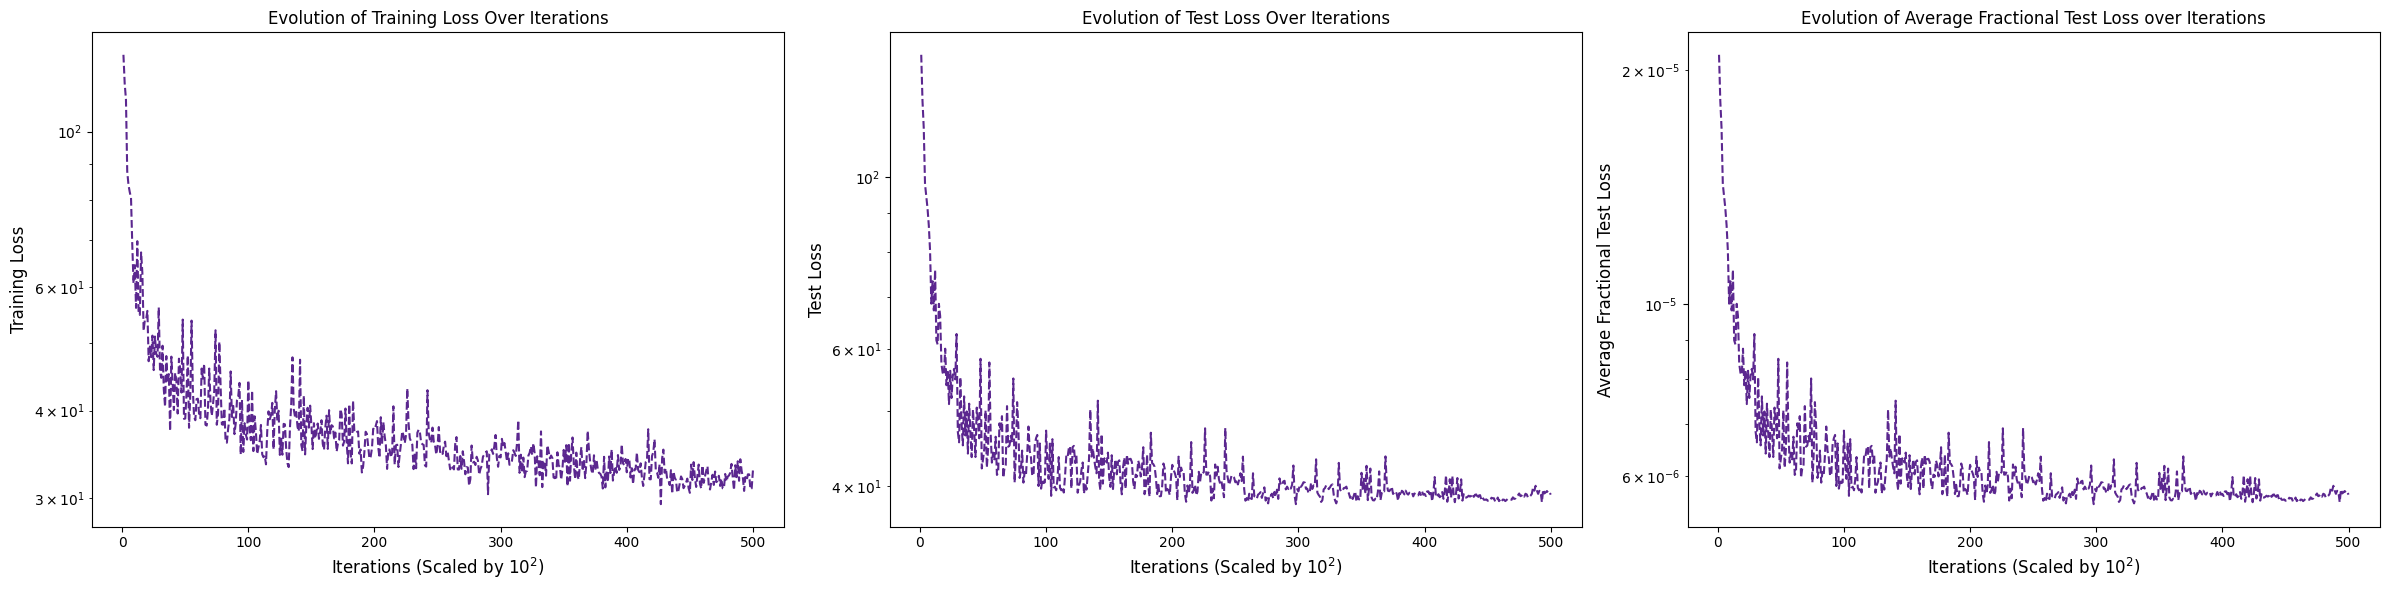

In [188]:
# Visualizations
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Colors from the 'viridis' colormap
medium_purple = '#5B278F'
light_purple = '#3b528b'
viri_green = '#00A896'

# Total loss per 100 iteration
total_loss_eval_numbers = range(1, len(model.loss_don_log) + 1)
axs[0].plot(total_loss_eval_numbers, model.loss_don_log, '--', color=medium_purple, label='Training loss')
axs[0].set_yscale('log')
axs[0].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[0].set_ylabel('Training Loss', fontsize='large')
axs[0].set_title('Evolution of Training Loss Over Iterations', fontsize='large')


# Test loss
test_loss_eval_numbers = range(1, len(model.loss_test_log) + 1)
axs[1].plot(test_loss_eval_numbers, model.loss_test_log, '--', color=medium_purple, label='Test loss')
axs[1].set_yscale('log')
axs[1].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[1].set_ylabel('Test Loss', fontsize='large')
axs[1].set_title('Evolution of Test Loss Over Iterations', fontsize='large')

# Average fractional test loss
AFTL_eval_numbers = range(1, len(model.loss_AF_test_log) + 1)
axs[2].plot(AFTL_eval_numbers, model.loss_AF_test_log, '--', color=medium_purple, label='Average Fractional Test loss')
axs[2].set_yscale('log')
axs[2].set_xlabel(r'Iterations (Scaled by $10^2$)', fontsize='large')
axs[2].set_ylabel('Average Fractional Test Loss', fontsize='large')
axs[2].set_title('Evolution of Average Fractional Test Loss over Iterations', fontsize='large')


plt.tight_layout()
plt.show()

###  **Visualise Predicted Solution of a New Test Function**  

In [189]:
def generate_test_data_visualization(key, P_test):

    # Sample collocation points
    x_test = jnp.linspace(0, x0, num=(int(P_test**0.5)))
    y_test = jnp.linspace(0, y0, num=(int(P_test**0.5)))
    t_test = jnp.linspace(0, T_lim, num=(int(P_test**0.5)))
    x_test_mesh, y_test_mesh = jnp.meshgrid(x_test, y_test)
    x_test = x_test_mesh.flatten().reshape(-1,1)
    y_test = y_test_mesh.flatten().reshape(-1,1)

    # Pre-allocate the array for efficiency
    z_test = jnp.zeros((len(t_test),P_test, 3))  # Shape: (number of time steps, 3 columns)

    # Testing collocation points
    for i, t in enumerate(t_test):
      # Create a single coordinate pair for each time step
      coordinates = jnp.hstack([x_test, y_test, t * jnp.ones_like(x_test)])
      z_test = z_test.at[i, :, :].set(coordinates)


    # Input sensor locations and measurements
    x_sensor = jnp.linspace(0, x0, int(m**0.5), endpoint = True)
    y_sensor = jnp.linspace(0, y0, int(m**0.5), endpoint = True)

    # Generate initial condition
    f, c_m, d_n = f_testing(2, key)
    f_test = jnp.tile(f(x_sensor,y_sensor).T, (P_test,1))

    u_test = jnp.zeros((len(t_test),P_test))  # Shape: (number of time steps, 3 columns)
    for i in range(len(t_test)):
      u_test = u_test.at[i,:].set(u(A_mn(c_m, d_n), z_test[i,:,0],z_test[i,:,1],z_test[i,:,2]))

    return f_test, z_test, u_test

In [190]:
P_test = 121
N_test = 1
key = random.PRNGKey(1122) # a new unseen key
keys = random.split(key, N_test)

config.update("jax_enable_x64", True)
f_test_vis, z_test_vis, u_test_vis = generate_test_data_visualization(key, P_test)

# #Reshape Data
# f_test = jnp.float32(f_test.reshape(N_test * P_test,-1))
# z_test = jnp.float32(z_test.reshape(N_test * P_test,-1))
# u_test = jnp.float32(u_test.reshape(N_test * P_test,-1))

# Predict
params = model.get_params(model.opt_state)
u_pred = jnp.zeros((11,P_test))

# Predict
for i in range(11):
  u_pred = u_pred.at[i,:].set(model.predict_u(params, f_test_vis, z_test_vis[i,:,:])[:,0])

In [191]:
# Generate an uniform mesh
x = jnp.linspace(0, x0, 121)
y = jnp.linspace(0, y0, 121)
XX, YY = jnp.meshgrid(x, y)

In [192]:
time_steps = jnp.linspace(0, T_lim, num=(int(P_test**0.5)))
# # Grid data
U_pred = jnp.zeros((11,121,121))
U_test = jnp.zeros((11,121,121))
for i in range(11):
  U_pred = U_pred.at[i].set(griddata(z_test_vis[i,:,:2], u_pred[i,:].flatten(), (XX,YY), method='cubic'))
  U_test = U_test.at[i].set(griddata(z_test_vis[i,:,:2], u_test_vis[i,:].flatten(), (XX,YY), method='cubic'))

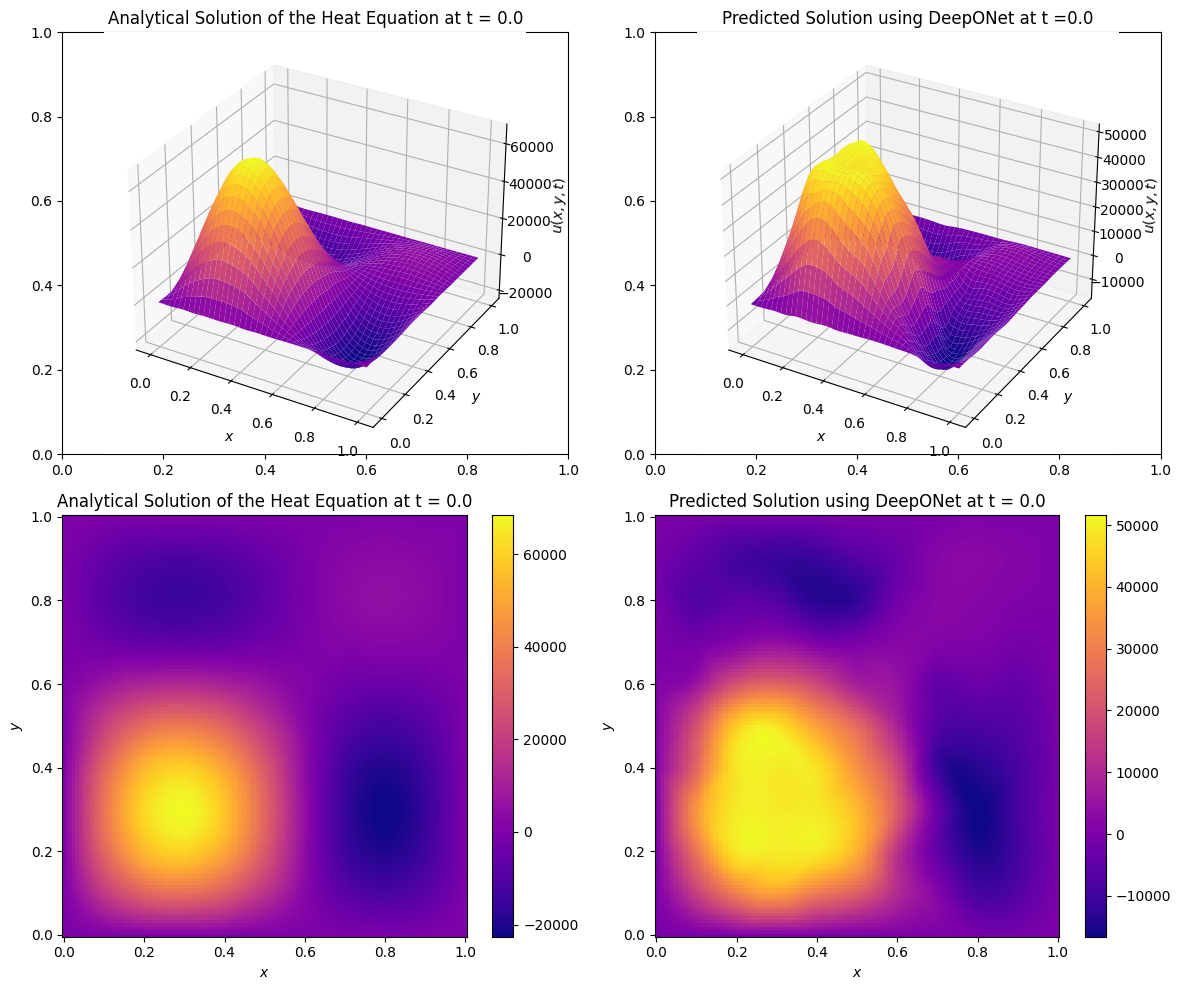

In [193]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[0,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[0]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[0,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t ={time_steps[0]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[0,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[0]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[0,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[0]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()


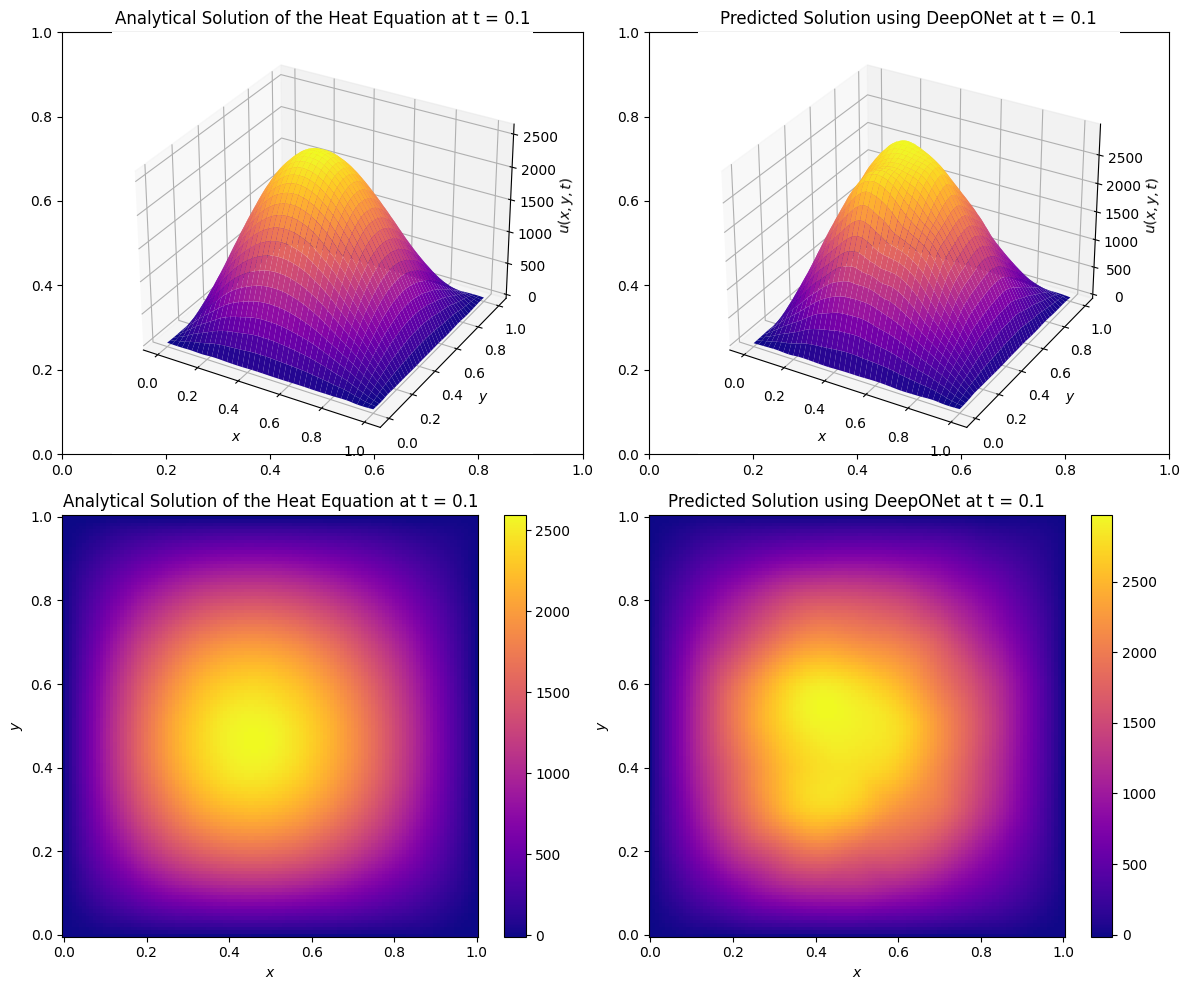

In [194]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[1,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[1]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[1,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[1]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[1,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[1]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[1,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[1]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

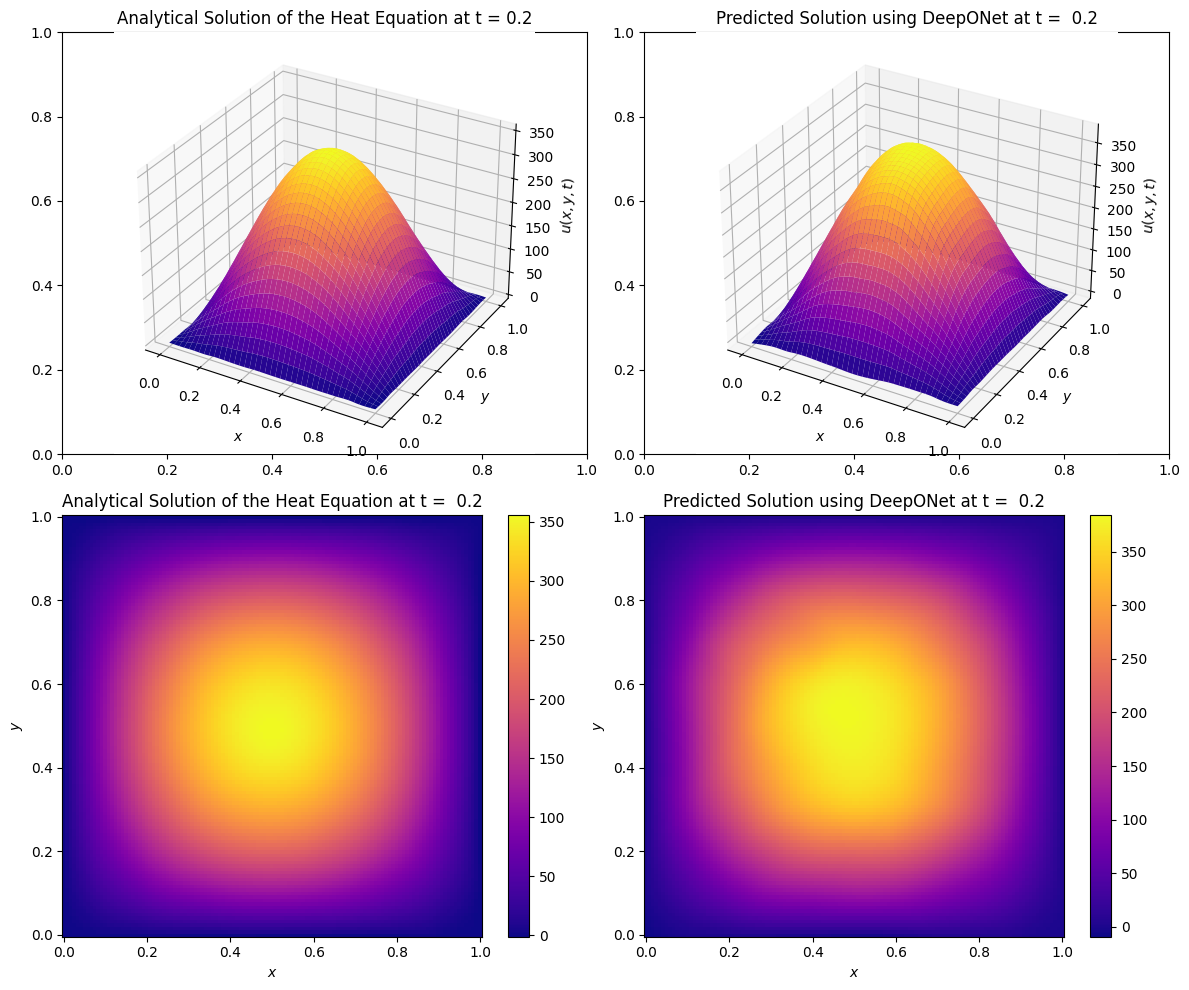

In [195]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[2,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[2]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[2,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t =  {time_steps[2]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[2,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t =  {time_steps[2]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[2,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t =  {time_steps[2]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

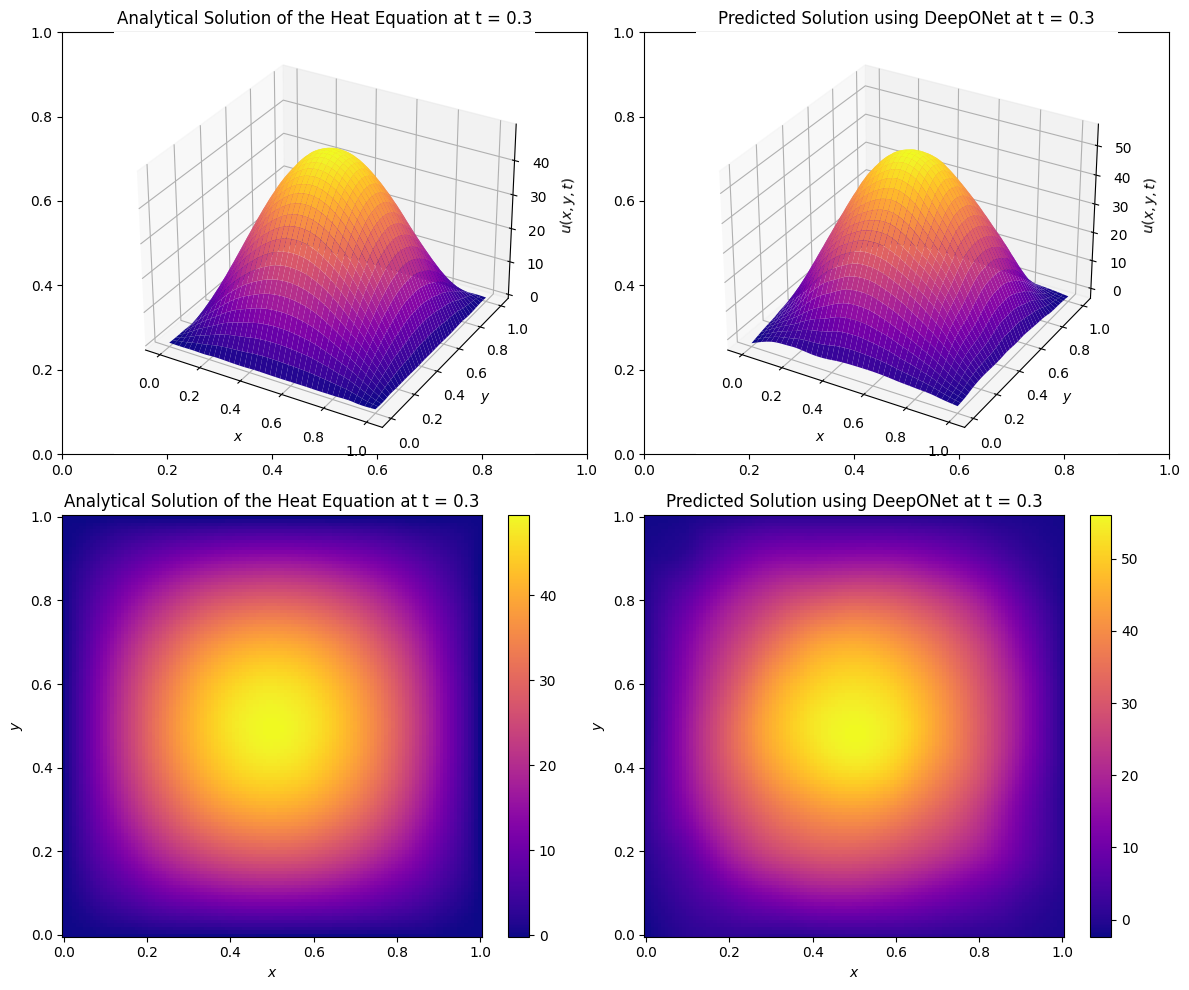

In [196]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[3,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[3]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[3,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[3]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[3,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[3]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[3,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[3]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()


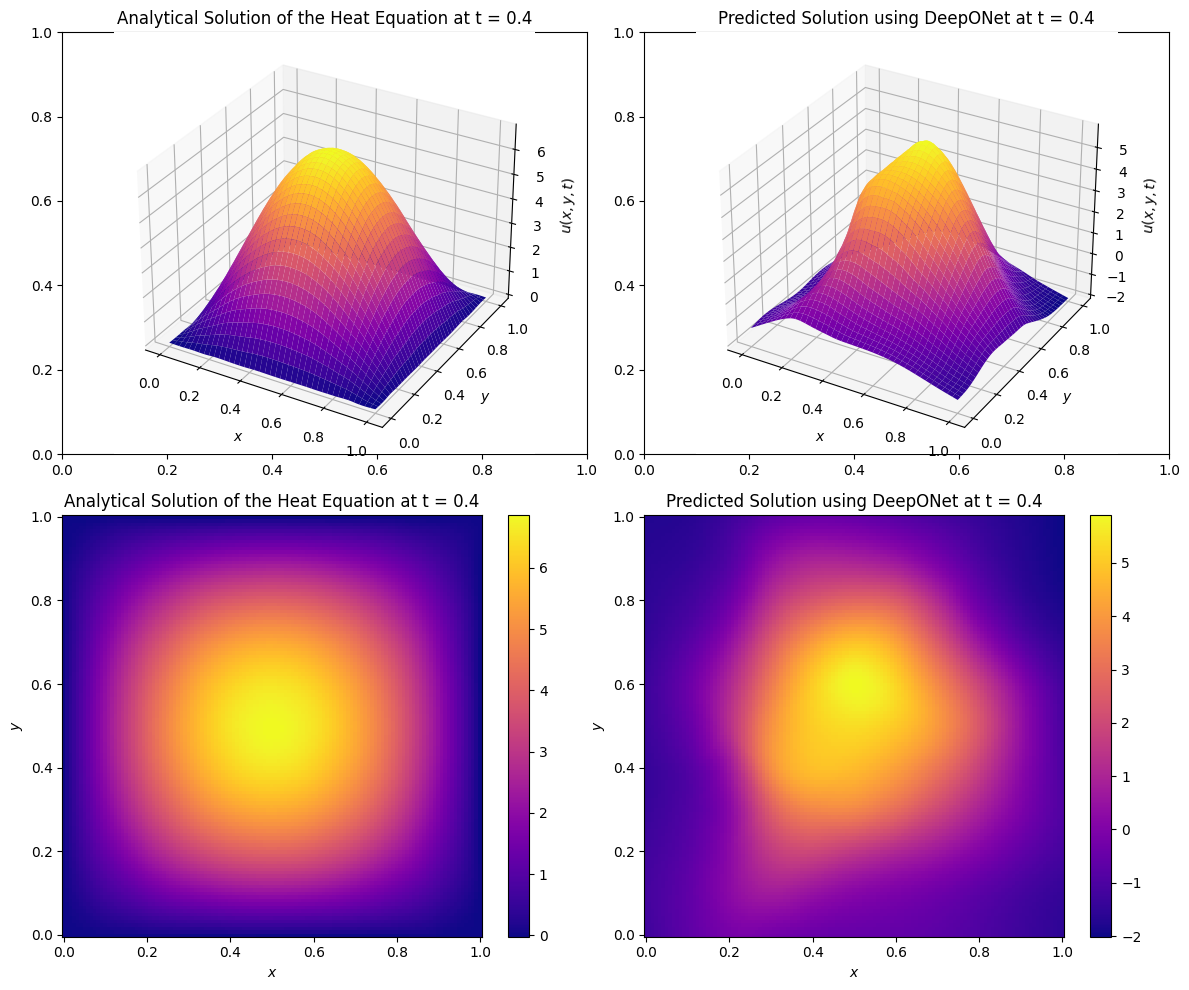

In [197]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[4,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[4]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[4,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[4]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[4,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[4]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[4,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[4]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

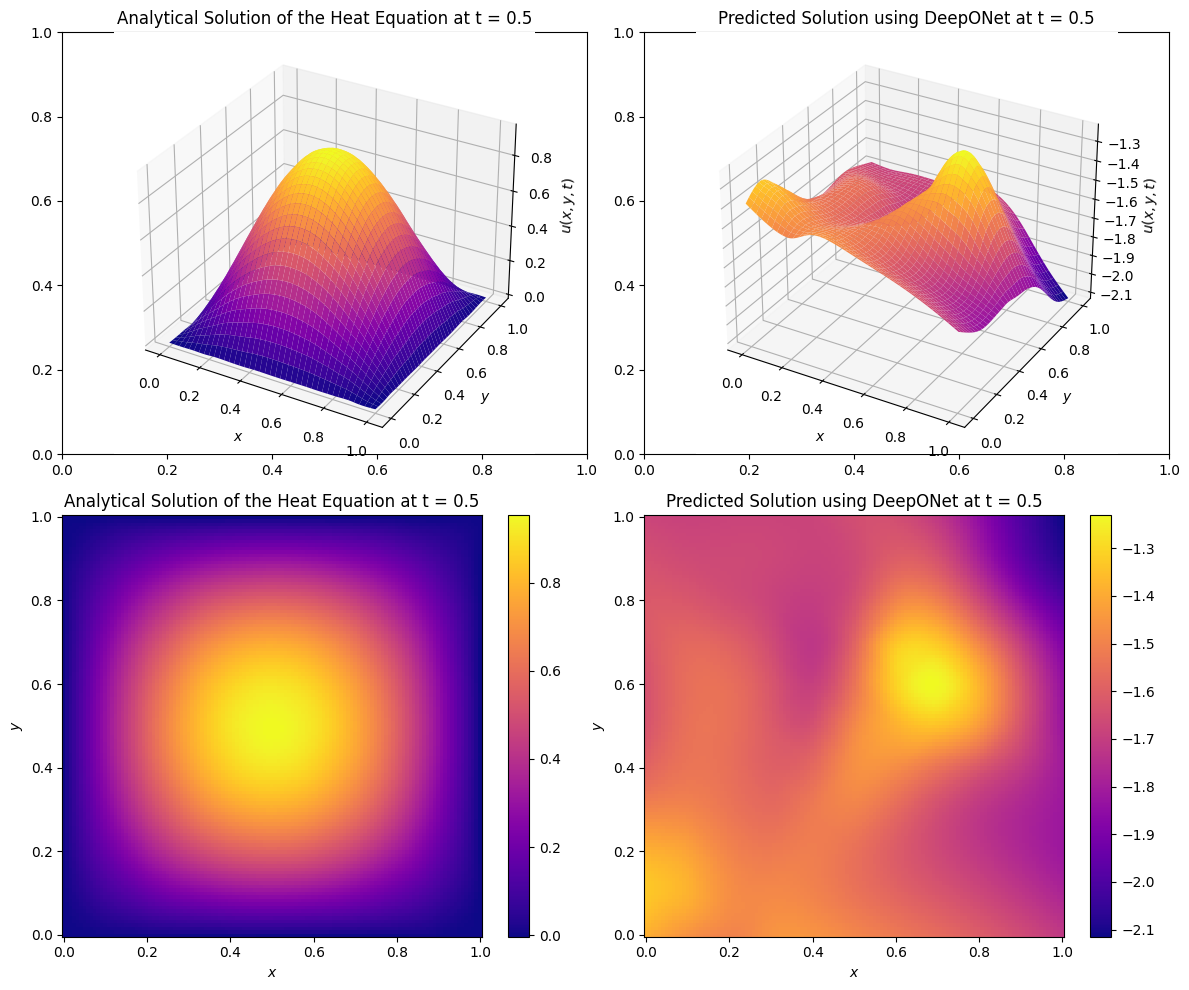

In [198]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[5,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[5]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[5,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[5]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[5,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[5]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[5,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[5]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

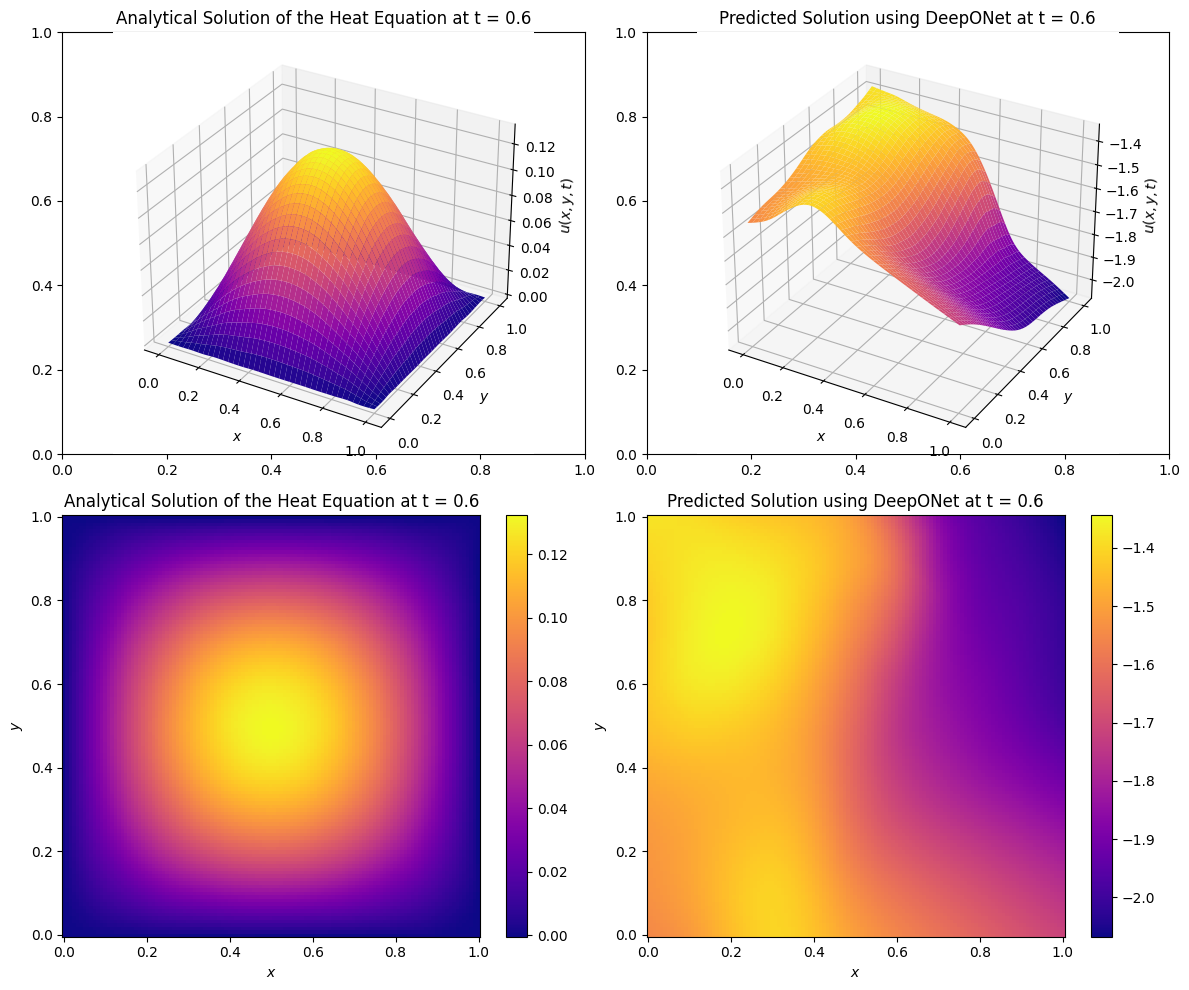

In [199]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[6,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[6]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[6,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[6]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[6,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[6]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[6,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[6]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

In [ ]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[7,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[7]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[7,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[7]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[7,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[7]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[7,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[7]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

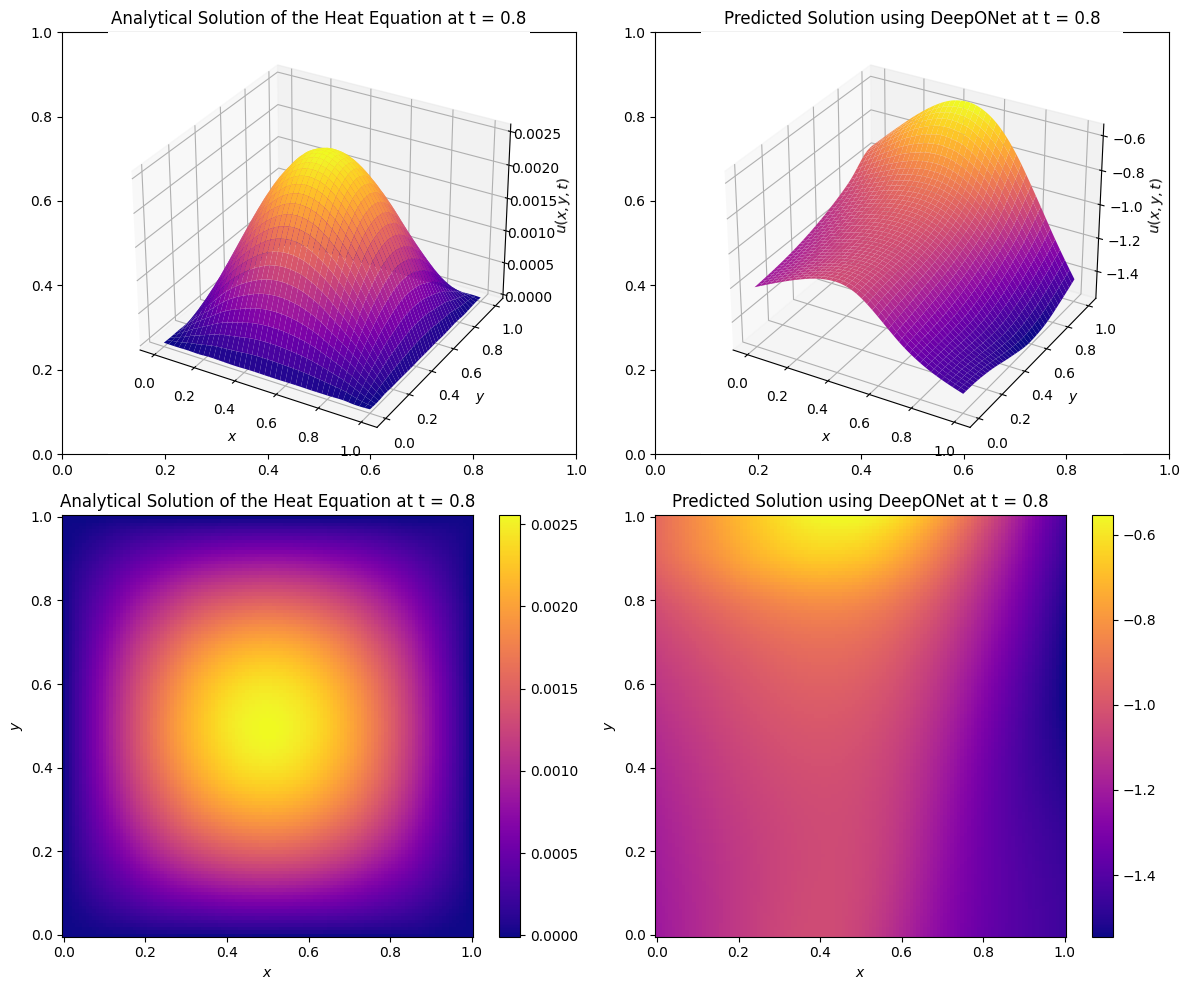

In [200]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[8,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[8]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[8,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[8]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[8,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[8]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[8,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[8]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

In [ ]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[9,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[9]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[9,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[9]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[9,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t = {time_steps[9]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[9,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[9]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()

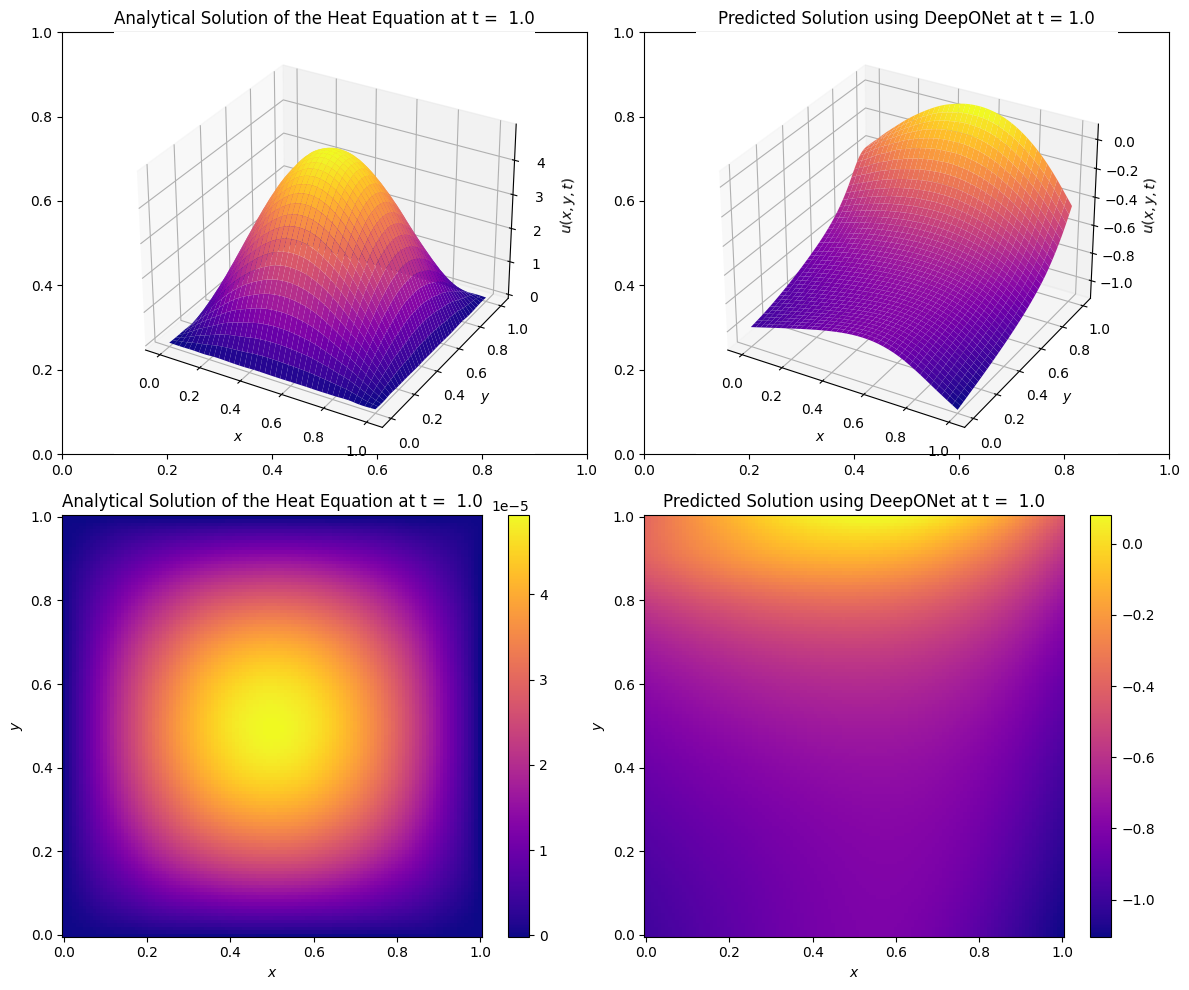

In [201]:
# Create a new figure with two rows of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Top row: 3D plots
# Analytical Solution of the Heat Equation
axs[0, 0] = fig.add_subplot(221, projection='3d')
plot_3d(axs[0, 0], XX, YY, U_test[10,:,:])
axs[0, 0].set_title(f"Analytical Solution of the Heat Equation at t =  {time_steps[10]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
axs[0, 1] = fig.add_subplot(222, projection='3d')
plot_3d(axs[0, 1], XX, YY, U_pred[10,:,:])
axs[0, 1].set_title(f"Predicted Solution using DeepONet at t = {time_steps[10]:.1f}", fontsize='large')

# Bottom row: 2D color plots
# Analytical Solution of the Heat Equation
plot(axs[1, 0], XX, YY, U_test[10,:,:])
axs[1, 0].set_title(f"Analytical Solution of the Heat Equation at t =  {time_steps[10]:.1f}", fontsize='large')

# Predicted Solution using DeepONet
plot(axs[1, 1], XX, YY, U_pred[10,:,:])
axs[1, 1].set_title(f"Predicted Solution using DeepONet at t =  {time_steps[10]:.1f}", fontsize='large')

plt.tight_layout()
plt.show()